# Generate input files for MOM6
Each cell corresponds to a different component of the initialization  
This includes grid, sponge, TS, wind forcing, buoyancy forcing  
Save netcdf files to the INPUT file of the configuration, with a simulation-specific name

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
rootdir = '/work/gam/MOM6/inputs/'
config = 'channel'
simulation = '8th-deg'

# Grid
Define the parameters of the grid  
Output the vertical and horizontal coordinate, and a 2D mesh of the horizontal coordinates  

*** Defined here, but is it also possible to load from the configuration directory? ***  
*** Perhaps will become necessary when more complicated grids, e.g. stretched, are used ***

<xarray.DataArray 'dz' (NK: 50)>
array([  1.      ,   3.347371,   5.922511,   8.629756,  11.433449,  14.313905,
        17.258474,  20.258282,  23.306733,  26.398718,  29.530156,  32.697707,
        35.898582,  39.130417,  42.391178,  45.679099,  48.992629,  52.330395,
        55.691172,  59.07386 ,  62.477467,  65.901091,  69.34391 ,  72.805169,
        76.284177,  79.780294,  83.292928,  86.821528,  90.365583,  93.924613,
        97.498172, 101.085839, 104.687218, 108.301939, 111.929649, 115.570016,
       119.222727, 122.887484, 126.564002, 130.252013, 133.95126 , 137.661499,
       141.382496, 145.114028, 148.855881, 152.607852, 156.369745, 160.14137 ,
       163.922549, 167.713106])
Coordinates:
  * NK       (NK) float64 0.5 2.674 7.309 14.58 ... 3.588e+03 3.75e+03 3.916e+03


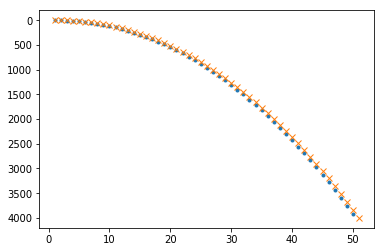

In [3]:
# ___ HORIZONTAL GRID ___#
# Specify geometry of horizontal grid
# MUST BE CONSISTENT WITH THE MODEL GRID
# Latitude and longitude
SOUTHLAT=-65.0
LENLAT=40.0
WESTLON=0.0
LENLON=60.0

# Number of grid cells
NI=int(LENLON*8)
NJ=int(LENLAT*8)

# Grid point positions (tracer point)
X=np.linspace(WESTLON,WESTLON+LENLON,NI+1)
X1d=(X[1:] + X[:-1]) / 2
Y=np.linspace(SOUTHLAT,SOUTHLAT+LENLAT,NJ+1)
Y1d=(Y[1:] + Y[:-1]) / 2
# 2D mesh of grid point positions
X,Y=np.meshgrid(X1d,Y1d)
# Define lat and lon dimensions set to zero at the midpoint
X0 = xr.DataArray(np.linspace(-NI/2,NI/2,NI),coords=[X1d],dims='lon')
Y0 = xr.DataArray(np.linspace(-NJ/2,NJ/2,NJ),coords=[Y1d],dims='lat')
# Define xarray data array with dimensions of horizontal grid
# (for broadcasting dimensions of other variables later in the notebook)
hgrid = xr.DataArray(np.ones([NI,NJ]),coords=[X1d,Y1d],dims=['lon','lat'])

# ___ VERTICAL GRID ___ #
# Specify geometry of vertical grid
# (based on MOM6 input parameters)

# Number of grid cells
NK = 50

MAXIMUM_DEPTH = 4000
MINIMUM_DEPTH = 0

# Resolve vertical grid
st = 1 # Thickness of topmost grid cell
z0 = MINIMUM_DEPTH + st
H = MAXIMUM_DEPTH
k = np.linspace(1,NK,num=NK)

# Defining INTERFACE locations (i.e. grid cell interfaces)
# Power law
B = np.log(H/z0)/np.log(NK)
zw = z0*k**B

# ---- #
# Additional code to calculate uniform and exponential spacing
# Uniform
# zw = np.linspace(z0,H,NK)
# Exponential
# zw = z0*np.exp(np.log(H/z0)*(k/(NK)))
# ---- #

# Add the free surface, z*=0, as an interface (saved until this point as z0=0 messes with power law scaling)
zw = np.append(0,zw)

# Central point is THICKNESS location
zt = (zw[1:] + zw[:-1]) / 2

# Place in data arrays
zw = xr.DataArray(zw,coords=[zw],dims=['NKp1'])
zt = xr.DataArray(zt,coords=[zt],dims=['NK'])
# Calculate thickness
dz = zw.diff(dim='NKp1')
dz = xr.DataArray(dz,coords=[zt],dims=['NK'])

# ___ SAVE VERTICAL GRID ___ #
# Combine arrays to one dataset
zw.name='zw'
zt.name='zt'
dz.name='dz'
vgrid = xr.merge([zw,zt,dz])
vgrid.to_netcdf(rootdir+config+'/'+simulation+'_vgrid'+'.nc')

# RECAST vgrid as dummy data array with dimensions of vertical tracer grid
# (for broadcasting dimensions of other variables later in the notebook)
vgrid = xr.DataArray(np.ones(NK),coords=[zt],dims=['depth'])

# Plot to check shape of vertical grid
plt.plot(k,zt,'.')
plt.plot(np.append(k,k[-1]+1),zw,'x')
plt.gca().invert_yaxis()
print(dz)

# Sponge
Specify the sponge region by **(A)** defining the inverse damping timescale IDAMP on a 2D horizontal mesh (zero everywhere outside of the sponge) and **(B)** defining the interface height variable ETA (arbitrary for ALE coordinates where it is just set to the vertical grid height).

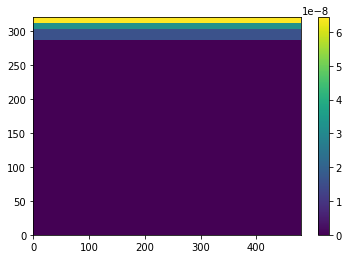

In [4]:
# ___ IDAMP ___ #
def set_sponge(idamp,idampval,ydamp):
    # idamp is an array with the same shape as the horizontal grid
    # idampval is the inverse damping rate (in s-1)
    # ydamp is the degrees of lat to damp over
    sponge_region = idamp.coords['lat']>SOUTHLAT+LENLAT-ydamp
    idamp=xr.where(sponge_region,idampval,idamp)
    return idamp

# Define the maximum width of the sponge region
sponge_max = 4
# Progressively build the sponge
idamp = 0*hgrid
idamp = set_sponge(idamp,1/(720*86400),sponge_max)
idamp = set_sponge(idamp,1/(360*86400),sponge_max/2)
idamp = set_sponge(idamp,1/(180*86400),sponge_max/4)
# Create boolean array of max sponge region for use with other initializations
sponge_region_max = idamp.coords['lat']>SOUTHLAT+LENLAT-sponge_max

# ___ ETA ___ #
# Set 'interface' height (just set to ALE coordinate z-grid)
# Broadcast depth across lat-lon domain
eta = xr.DataArray(-zw,coords=[zw],dims='depthe')
eta = eta*hgrid

# ___ SAVE OUTPUT ___ #
# Combine arrays to one dataset
idamp.name='idamp'
eta.name='eta'
sponge = xr.merge([idamp,eta])
sponge = sponge.transpose('depthe','lat','lon')
sponge.to_netcdf(rootdir+config+'/'+simulation+'_sponge'+'.nc')

# Plot to check
im=plt.pcolormesh(idamp)
plt.colorbar(im)

# Temperature and salinity
Define temperature and salinity on the model grid  
Output should be **(A)** a 3D field of temperature and salinity, and **(B)** a 2D field of SST and SSS (for use with surface restoring)

*** Temperature and salinity can be defined in a number of ways, in the first instance I am using analytic profiles. These were fit, by eye, to WOA data in gen_mom6-in_tsprofile. Salinity is just set to a constant value ***

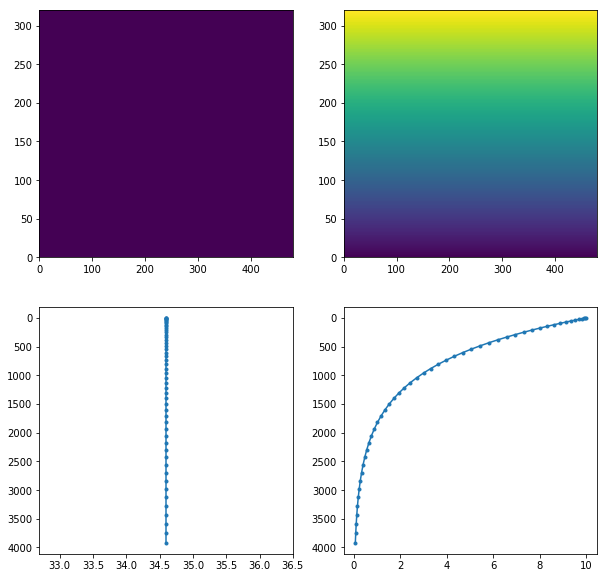

In [5]:
# ___ SURFACE ___ #

# SALINITY as a constant
Sref = 34.6
SSS = Sref*hgrid

# TEMPERATURE as a first order polynomial
# Boundary conditions
Tn = 10
Ts = 0
A = (Tn-Ts)/LENLAT
B = Ts - SOUTHLAT*A
T = A*hgrid.lat+B
SST = T*hgrid

# ___ PROFILE ___ #

# SALINITY as a constant
S = SSS*vgrid
# TEMPERATURE as an exponential
Z0 = 800 # e-folding depth
T = SST*np.exp(-vgrid.depth/Z0)

# ___ SAVE OUTPUT ___ #
# Combine arrays to one dataset
SSS.name='SSS'
SST.name='SST'
S.name='S'
T.name='T'
TS = xr.merge([SSS,SST,S,T])
TS = TS.transpose('depth','lat','lon')
TS.to_netcdf(rootdir+config+'/'+simulation+'_TS'+'.nc')

# ___ APPEND T,S TO SPONGE FILE ___ #
### HACK TO IMPOSE DIMENSION ORDER ###
# OVERWRITE SAVED SPONGE VARIABLE #
# THIS IS SILLY BUT ALL I CAN DO AT THE MOMENT #
sponge = xr.merge([eta,idamp,T,S])
sponge = sponge.transpose('depthe','depth','lat','lon')
sponge.to_netcdf(rootdir+config+'/'+simulation+'_sponge'+'.nc')

# Plot to check
fig,ax=plt.subplots(figsize=[10,10],ncols=2,nrows=2)
ax[0,0].pcolormesh(SSS.transpose())
ax[0,1].pcolormesh(SST)
ax[1,0].plot(S.sel(lon=50,lat=10,method='nearest'),S.depth,marker='.')
ax[1,1].plot(T.sel(lon=50,lat=10,method='nearest'),T.depth,marker='.')
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()

# Wind forcing
Impose a wind forcing pattern across the channel  

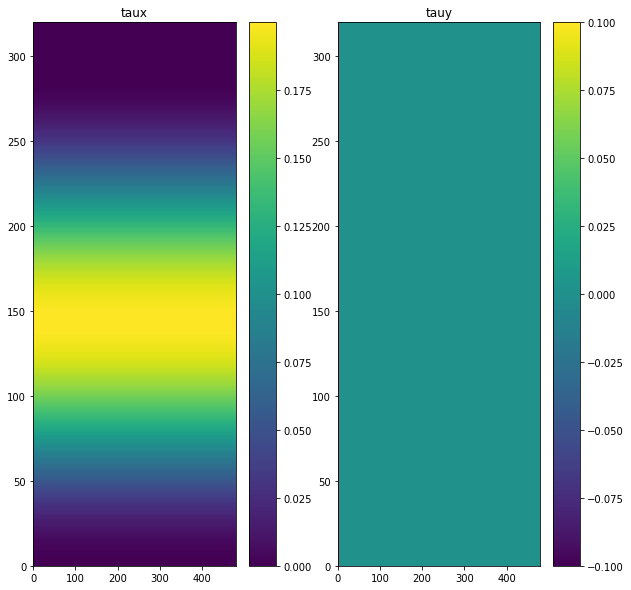

In [6]:
# ___ LATITUDINAL PROFILE ___ #
taux_ref = 0.2
tauy_ref = 0.0
zero_at_sponge = True

# Cosine bell
def cosbell(x):
    a0 = 0.5
    return a0+(1-a0)*np.cos((2*np.pi*x)/x.size)

if zero_at_sponge:
    # Get size of the array outside the sponge region
    NJnew = Y0.lat[~sponge_region_max].size
    # Shift the centered coordinate, Y0
    Y0shift = xr.DataArray(np.linspace(-NJnew/2,NJnew/2,NJnew),coords=[Y1d[~sponge_region_max]],dims='lat')
    # Evaluate a cosine bell outside the sponge region
    taux = taux_ref*cosbell(Y0shift)
    # Create a zero array inside the sponge region
    taux_zeros = xr.DataArray(np.zeros(NJ),coords=[Y1d],dims=['lat']) # Across all latitudes
    taux_zeros = taux_zeros[sponge_region_max] # Isolated in the sponge region
    # Append the two arrays
    taux = xr.concat([taux, taux_zeros],dim='lat')
else:
    taux=taux_ref*cosbell(Y0)

# ---- #
# Additional code to do gaussian profile
# middle = SOUTHLAT+LENLAT/2
# width = LENLAT/6
# Gaussian
# def gaussian(x, middle, width):
#    return np.exp(-np.power(x - middle, 2.) / (2 * np.power(width, 2.)))

# taux=xr.DataArray(taux_ref*gaussian(hgrid.lat,middle,width),coords=[Y1d],dims=['lat'])

# Taper in sponge region
# if zero_at_sponge:
#    taux=xr.where(sponge_region,0,taux)
# ---- #

# Extend to 2D array
taux=taux*hgrid
tauy=tauy_ref*hgrid

# ___ SAVE OUTPUT ___ #
# Combine arrays to one dataset
taux.name='taux'
tauy.name='tauy'
wind = xr.merge([taux,tauy])
wind = wind.transpose('lat','lon')
wind.to_netcdf(rootdir+config+'/'+simulation+'_wind'+'.nc')

# Plot to check
fig,ax=plt.subplots(figsize=[10,10],ncols=2)
im=ax[0].pcolormesh(wind.taux)
plt.colorbar(im,ax=ax[0])
ax[0].set_title('taux')
im=ax[1].pcolormesh(wind.tauy)
plt.colorbar(im,ax=ax[1])
ax[1].set_title('tauy');

# Buoyancy forcing
Set the buoyancy forcing at the surface, including longwave and shortwave radiation, latent and sensible heat flux, evaporation, and precipitation  

*** For just now, set these fluxes to zero and let the restoring do everything ***

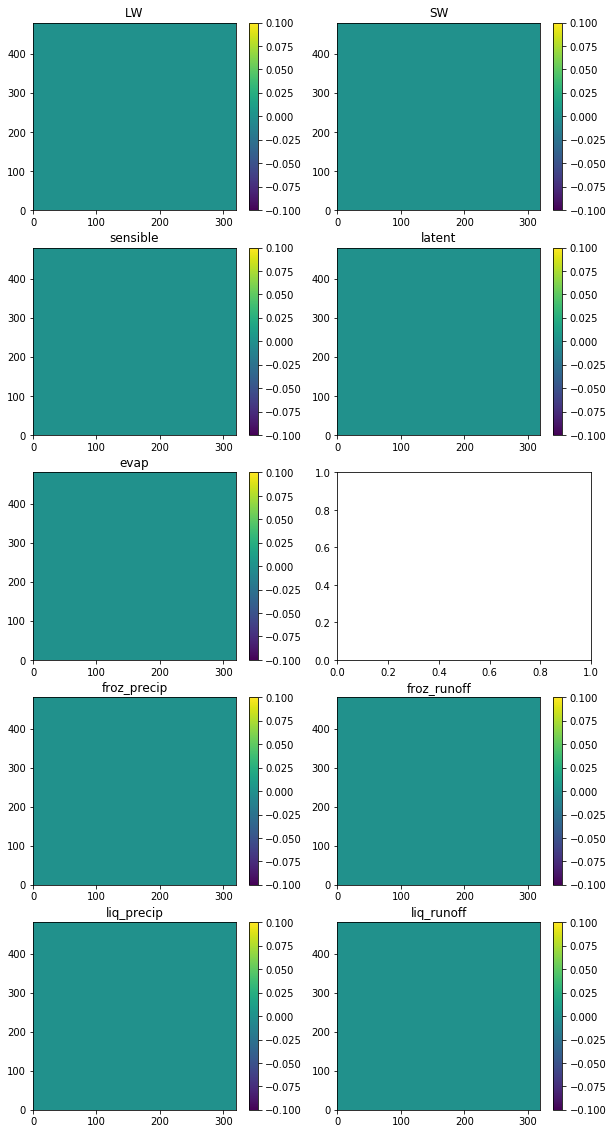

In [7]:
# Define buoyancy forcing on grid
LW_ref=0.0
SW_ref=0.0
sensible_ref = 0.0
latent_ref = 0.0
evap_ref = 0.0
froz_precip_ref = 0.0
froz_runoff_ref = 0.0
liq_precip_ref = 0.0
liq_runoff_ref = 0.0

# Uniform
LW = LW_ref*hgrid
SW = SW_ref*hgrid
sensible = sensible_ref*hgrid
latent = latent_ref*hgrid
evap = evap_ref*hgrid
froz_precip = froz_precip_ref*hgrid
froz_runoff = froz_runoff_ref*hgrid
liq_precip = liq_precip_ref*hgrid
liq_runoff = liq_runoff_ref*hgrid

# ___ SAVE OUTPUT ___ #
# Combine arrays to one dataset
LW.name='LW'
SW.name='SW'
sensible.name='sensible'
latent.name='latent'
evap.name='evap'
froz_precip.name='froz_precip'
froz_runoff.name='froz_runoff'
liq_precip.name='liq_precip'
liq_runoff.name='liq_runoff'

buoyancy = xr.merge([LW,SW,sensible,latent,evap,froz_precip,froz_runoff,liq_precip,liq_runoff])
buoyancy = buoyancy.transpose('lat','lon')
buoyancy.to_netcdf(rootdir+config+'/'+simulation+'_buoyancy'+'.nc')

# Plot to check
fig,ax=plt.subplots(figsize=[10,20],ncols=2,nrows=5)
def splot(pos,var,varstr):
    im=ax[pos[0],pos[1]].pcolormesh(var)
    plt.colorbar(im,ax=ax[pos[0],pos[1]])
    ax[pos[0],pos[1]].set_title(varstr)

splot([0,0],LW,'LW')
splot([0,1],SW,'SW')
splot([1,0],sensible,'sensible')
splot([1,1],latent,'latent')
splot([2,0],evap,'evap')

splot([3,0],froz_precip,'froz_precip')
splot([3,1],froz_runoff,'froz_runoff')
splot([4,0],liq_precip,'liq_precip')
splot([4,1],liq_runoff,'liq_runoff')

# Velocity
Allow input of a specific zonal velocity perturbation

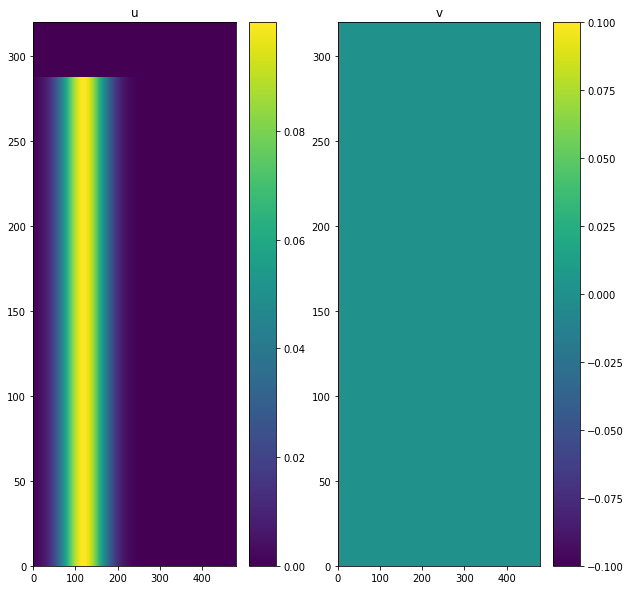

In [8]:
# ___ LONGITUDINAL PROFILE ___ #
u_ref = 0.1
v_ref = 0.0

middle = WESTLON+LENLON/4
width = LENLON/12

# Gaussian nudge
def gaussian(x, middle, width):
    return np.exp(-np.power(x - middle, 2.) / (2 * np.power(width, 2.)))

u=xr.DataArray(u_ref*gaussian(hgrid.lon,middle,width),coords=[X1d],dims=['lon'])

# Taper in sponge region
u=xr.where(sponge_region_max,0,u)

# Extend to 3D array
u=u*hgrid*vgrid
v=v_ref*hgrid*vgrid

# ___ SAVE OUTPUT ___ #
# Combine arrays to one dataset
u.name='u'
v.name='v'
velocity = xr.merge([u,v])
velocity = velocity.transpose('depth','lat','lon')
velocity.to_netcdf(rootdir+config+'/'+simulation+'_velocity'+'.nc')

# Plot to check
fig,ax=plt.subplots(figsize=[10,10],ncols=2)
im=ax[0].pcolormesh(velocity.u.sel(depth=0,method='nearest'))
plt.colorbar(im,ax=ax[0])
ax[0].set_title('u')
im=ax[1].pcolormesh(velocity.v.sel(depth=0,method='nearest'))
plt.colorbar(im,ax=ax[1])
ax[1].set_title('v');


# Topography
Presently just using user-designed topography, with an approach borrowed from Luwei Yang
In future, I intend to use iterations of more realistic topography

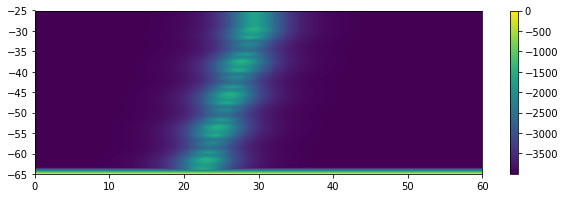

In [11]:
# ___ CREATE TOPOGRAPHY ___ #
# Note that MOM6 takes DEPTH (not HEIGHT) for its topography, so it is positive number

def create_ridge(D=0,A=500,p=1,o=0,r=0,w=1):
    # Create a bumpy ridge by setting a sine wave in the meridional direction and multiplying 
    ridge = (D+A*np.sin(p*(2*np.pi)/LENLAT*hgrid.lat))/np.cosh((X0+o+r*Y0)/w)
    return ridge

# Set bathymetry to maximum depth
depth = MAXIMUM_DEPTH*hgrid

# Create RIDGE 1
D = 2000 # Height off maximum depth
A = 400 # Sine wave amplitude
p = 5 # Wavenumber of ridge in latitude
o = LENLON/2 # Longitudinal offset from centre (positive is to the left)
r = -0.2 # Rotation (poitive is anti-clockwise)
w = 20 # Longitudinal width factor (>1 increases the width, <1 decreases)
r1 = create_ridge(D,A,p,o,r,w)

# Create RIDGE 2
D = 0
A = 200 # Sine wave amplitude
p = 20 # Wavenumber of ridge in latitude
w = 10 # Longitudinal width factor (>1 increases the width, <1 decreases)
r2 = create_ridge(D,A,p,o,r,w)

# Create RIDGE 3
D = 0
A = 100 # Sine wave amplitude
p = 30 # Wavenumber of ridge in latitude
w = 5 # Longitudinal width factor (>1 increases the width, <1 decreases)
r3 = create_ridge(D,A,p,o,r,w)

# Create RIDGE 2, 3, 4 etc.

# Add ridges to bathymetry
depth = depth - r1 - r2 - r3

# Add a continental slope next to Antarctica
depth = np.minimum(depth,3e2*(Y0+NJ/2))

# Unify meridional depth within the sponge layer
# Set topography in sponge region to be the same as the depth at its most southerly grid cell
depth=xr.where(sponge_region_max,depth.sel(lat=sponge_region_max).isel(lat=0),depth)

# Impose minimum depth
depth=xr.where(depth<MINIMUM_DEPTH,MINIMUM_DEPTH,depth)

# ___ SAVE OUTPUT ___ #
# Combine arrays to one dataset
depth.name='depth'
depth.transpose('lat','lon')
depth.to_netcdf(rootdir+config+'/'+simulation+'_topography'+'.nc')

# Plot to check
fig,ax=plt.subplots(figsize=(10,3),nrows=1)
im=plt.pcolormesh(hgrid.lon,hgrid.lat,-depth)
plt.colorbar(im)